In [73]:
''' use pca to extract characteristic of signal
then use transformer to fit; probably voigt function/Gaussian line shape'''
import os  
import numpy as np
import struct
import matplotlib.pyplot as plt
import gc
import random
import math
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, LayerNormalization
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras import initializers
import sklearn
# from scipy.interpolate import CubicSpline
from scipy.signal import find_peaks
from scipy.interpolate import interp1d
from sklearn.decomposition import PCA as PCA

In [95]:
with open("dataset_test.bin", "rb") as file0:
    data1 = file0.read(4)
    NM1 = struct.unpack("i", data1)[0]
    sig2 = np.zeros((NM1,200),dtype = np.float32)
    an2 = np.zeros((NM1,4),dtype = np.float32)
    for i in range(NM1):
        for k in range(4):
            data1 = file0.read(4)
            an2[i,k] = struct.unpack("f", data1)[0]
        for k in range(200):
            data1 = file0.read(4)
            sig2[i,k] = struct.unpack("f", data1)[0]  
    # data1 = file0.read(len('end\0'))
    # end = struct.unpack("4s", data1)[0]  

In [96]:
with open("dataset.bin", "rb") as file0:
    data1 = file0.read(4)
    NM1 = struct.unpack("i", data1)[0]
    sig1 = np.zeros((NM1,200),dtype = np.float32)
    an1 = np.zeros((NM1,4),dtype = np.float32)
    for i in range(NM1):
        for k in range(4):
            data1 = file0.read(4)
            an1[i,k] = struct.unpack("f", data1)[0]
        for k in range(200):
            data1 = file0.read(4)
            sig1[i,k] = struct.unpack("f", data1)[0]  
    # data1 = file0.read(len('end\0'))
    # end = struct.unpack("4s", data1)[0]  

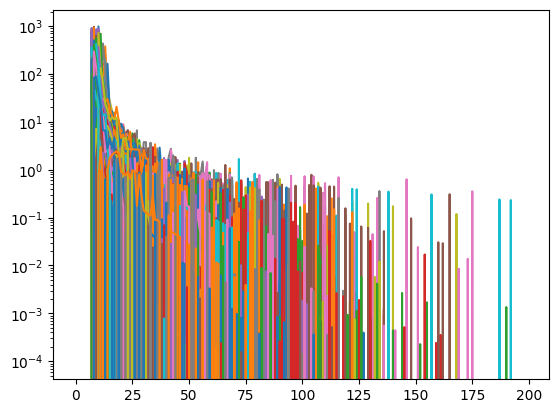

1262
[1.24224685e-02 9.14926987e+01 1.54261023e+03 8.50000024e-01]


In [4]:
plt.axes(yscale = "log") 
for n in range(sig1.shape[0]):
    plt.plot(sig1[n])
plt.show()
print(NM1)
print(an2[-1])

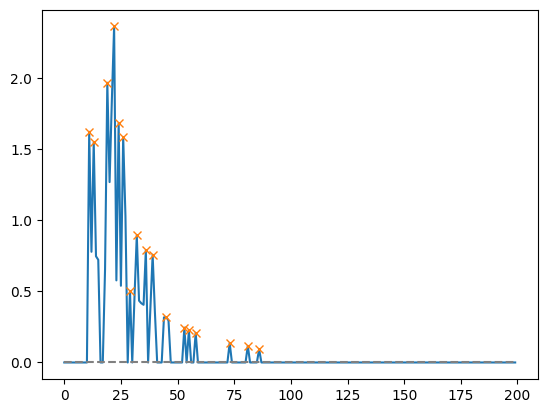

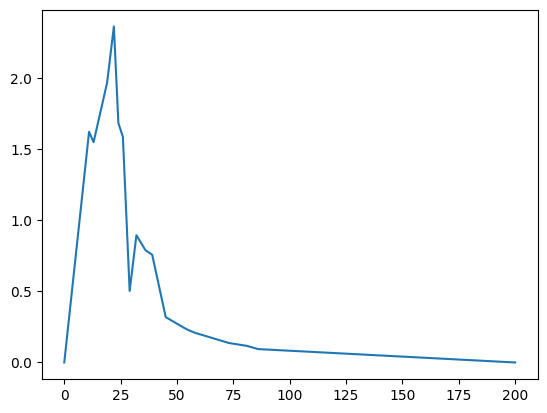

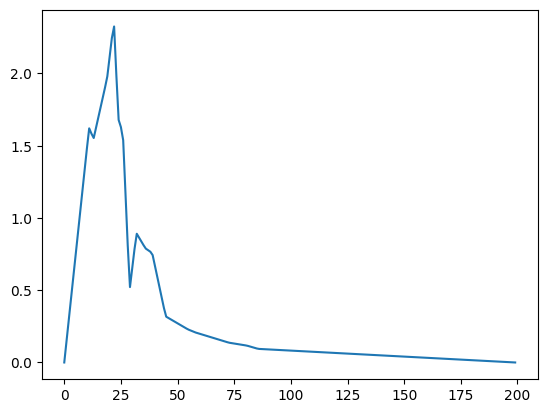

In [97]:
xsig = sig1[0]
peaks, _ = find_peaks(xsig, height=0)
plt.plot(xsig)
plt.plot(peaks, xsig[peaks], "x")
plt.plot(np.zeros_like(xsig), "--", color="gray")
plt.show()

x = np.zeros((peaks.shape[0]+2,))
y = np.zeros((peaks.shape[0]+2,))
x[1:-1] = peaks
y[1:-1] = xsig[peaks]
x[-1] = sig1.shape[1]
plt.plot(x,y)
plt.show()

f2 = interp1d(x, y, kind='linear')
N = 200
xnew = np.linspace(0, N,num=N)
ynew = f2(xnew)

# plt.axes(yscale = "log") 
plt.plot(ynew)
plt.show()

In [98]:
def smooth_peak(xsig):
    peaks, _ = find_peaks(xsig, height=0)
    # plt.plot(xsig)
    # plt.plot(peaks, xsig[peaks], "x")
    # plt.plot(np.zeros_like(xsig), "--", color="gray")
    # plt.show()
    if(peaks.shape[0]!=0):
        x = np.zeros((peaks.shape[0]+3,))
        y = np.zeros((peaks.shape[0]+3,))
        x[1:-2] = peaks
        y[1:-2] = xsig[peaks]
        x[-1] = sig1.shape[1]
        y[-1] = 0
        x[-2] = peaks[-1]+5
        y[-2] = 0
        # plt.plot(x,y)
        # plt.show()

        f2 = interp1d(x, y, kind='linear')
        N = xsig.shape[0]
        xnew = np.linspace(0, N,num=N)
        ynew = f2(xnew)
    
    else:
        ynew = np.zeros((xsig.shape[0],))
    
    return ynew
#     # plt.axes(yscale = "log") 
#     plt.plot(ynew)
#     plt.show()
    

In [99]:
msig1 = np.zeros((sig1.shape[0],sig1.shape[1]))
for i in range(sig1.shape[0]):
    msig1[i] = smooth_peak(sig1[i])
    
msig2 = np.zeros((sig2.shape[0],sig2.shape[1]))
for i in range(sig2.shape[0]):
    msig2[i] = smooth_peak(sig2[i])

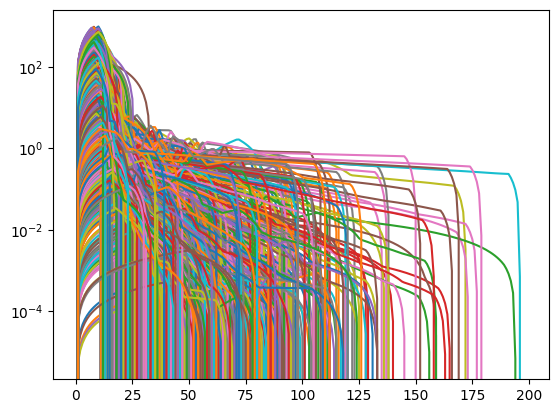

In [100]:
plt.axes(yscale = "log") 
for n in range(msig1.shape[0]):
    plt.plot(msig1[n])
plt.show()

In [101]:
print(sig1.shape)
print(an1.shape)
print(sig2.shape)
print(an2.shape)
# num_labels = 10
x_train = msig1
y_train = an1   # y_train : [thickness,mua,mus,g]
x_test = msig2
y_test = an2

x_train = (np.log10((x_train+1e-6)/1000)+9)/9   # 归一化
x_test = (np.log10((x_test+1e-6)/1000)+9)/9

n_components = 4
pca = PCA(n_components)
pca.fit(x_train)
# 转换数据并提取主成分
features = pca.transform(x_train)       # PCA
loading = pca.components_
x_train = features

n_components = 4
pca = PCA(n_components)
pca.fit(x_test)
# 转换数据并提取主成分
features = pca.transform(x_test)
loading = pca.components_
x_test = features

x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))    # reshape
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))
d_train = np.reshape(y_train[:,0],(y_train[:,0].shape[0],1,1)) # add thickness of sample into input data
d_test = np.reshape(y_test[:,0],(y_test[:,0].shape[0],1,1))

y_train[:,1] = y_train[:,1]/1e2
y_test[:,1] = y_test[:,1]/1e2
y_train[:,2] = y_train[:,2]/200e2
y_test[:,2] = y_test[:,2]/200e2
y_train = y_train[:,1:3] # determine the nn to output mua/mus or mua+mus
y_test = y_test[:,1:3]
# y_train = labeling(y_train,num_labels)[:,1,:] # select to predict what : 0:thickness 1:mua 2: mus
# y_test = labeling(y_test,num_labels)[:,1,:]
print('x_train.shape = '+str(x_train.shape)) 
print('y_train.shape = '+str(y_train.shape)) 
print('d_train.shape = '+str(d_train.shape)) 


(1262, 200)
(1262, 4)
(30, 200)
(30, 4)
x_train.shape = (1262, 4, 1)
y_train.shape = (1262, 2)
d_train.shape = (1262, 1, 1)


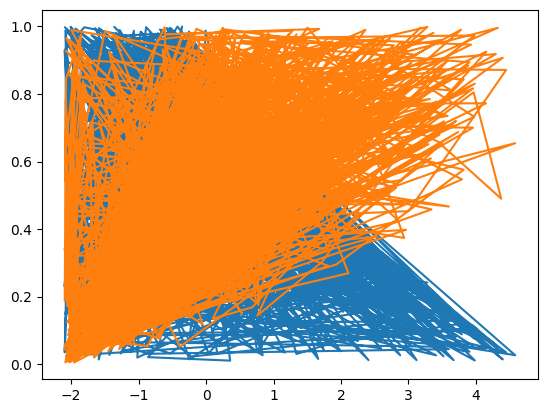

In [102]:
plt.plot(x_train[:,0,0],y_train[:,0])
plt.plot(x_train[:,0,0],y_train[:,1])
plt.show()

In [103]:
# Custom Transformer layer
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(TransformerBlock, self).__init__()

        self.mha = tf.keras.layers.MultiHeadAttention(num_heads, d_model)
        self.ffn = tf.keras.Sequential([
            Dense(dff, activation='relu', kernel_initializer=initializers.RandomNormal(stddev=0.01),
            bias_initializer=initializers.Zeros()),
            Dense(d_model)
        ])

        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'tf.keras.layers.MultiHeadAttention(num_heads, d_model)': self.mha,
            'tf.keras.Sequential([Dense(dff, activation=\'relu\'),Dense(d_model)])': self.ffn,
            'LayerNormalization(epsilon=1e-6)': self.layernorm1,
            'LayerNormalization(epsilon=1e-6)': self.layernorm2,
            'tf.keras.layers.Dropout(rate)': self.dropout1,
            'tf.keras.layers.Dropout(rate)': self.dropout2,
            })
        
        return config
    
    def call(self, x, training):
        attn_output, _ = self.mha(x, x, return_attention_scores=True)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)

        return out2

In [104]:
# Parameters
d_model = 16
num_heads = 4
dff = 12
dropout_rate = 0.1
input_shape = (4, 1)

# Model architecture
inputs1 = Input(shape=input_shape)
inputs2 = Input(shape=(1,1))
inputs = keras.layers.concatenate([inputs1, inputs2],axis = 1)
x = TransformerBlock(d_model, num_heads, dff, dropout_rate)(inputs)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
outputs = Dense(2,activation='linear')(x)

model = Model(inputs=[inputs1,inputs2], outputs=outputs)


In [76]:
# train model with code generated by gpt
# Model compilation and training
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse')

# x_train = # Your input data with shape (1258, 4, 1)
# y_train = # Your target data with shape (1258, 2)

model.fit([x_train,d_train], y_train, epochs=100, batch_size=32)

Epoch 1/100
40/40 [==============================] - 1s 11ms/step - loss: 1.0508
Epoch 2/100
40/40 [==============================] - 0s 10ms/step - loss: 0.1033
Epoch 3/100
40/40 [==============================] - 0s 10ms/step - loss: 0.0978
Epoch 4/100
40/40 [==============================] - 0s 10ms/step - loss: 0.1001
Epoch 5/100
40/40 [==============================] - 0s 10ms/step - loss: 0.0987
Epoch 6/100
40/40 [==============================] - 0s 10ms/step - loss: 0.0967
Epoch 7/100
40/40 [==============================] - 0s 10ms/step - loss: 0.0964
Epoch 8/100
40/40 [==============================] - 0s 10ms/step - loss: 0.0945
Epoch 9/100
40/40 [==============================] - 0s 10ms/step - loss: 0.0977
Epoch 10/100
40/40 [==============================] - 0s 10ms/step - loss: 0.0939
Epoch 11/100
40/40 [==============================] - 0s 10ms/step - loss: 0.0943
Epoch 12/100
40/40 [==============================] - 0s 10ms/step - loss: 0.0943
Epoch 13/100
40/40 [=====

In [105]:
epochs = 500
batch_size = 32
#####################################################
index = [i for i in range(x_train.shape[0])]  
np.random.shuffle(index) 
x_train = x_train[index]
y_train = y_train[index]
####################################################
callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_tf.keras.Model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    # loss="mean_squared_error",
    loss="mean_absolute_error",
    metrics=["MeanAbsoluteError"],
)
history = model.fit(
    [x_train,d_train],
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.4,
    verbose=1,
)

Epoch 1/500
24/24 [==============================] - 2s 24ms/step - loss: 0.7091 - mean_absolute_error: 0.7091 - val_loss: 0.2684 - val_mean_absolute_error: 0.2684
Epoch 2/500
24/24 [==============================] - 0s 14ms/step - loss: 0.2815 - mean_absolute_error: 0.2815 - val_loss: 0.2455 - val_mean_absolute_error: 0.2455
Epoch 3/500
24/24 [==============================] - 0s 13ms/step - loss: 0.2693 - mean_absolute_error: 0.2693 - val_loss: 0.2479 - val_mean_absolute_error: 0.2479
Epoch 4/500
24/24 [==============================] - 0s 14ms/step - loss: 0.2651 - mean_absolute_error: 0.2651 - val_loss: 0.2498 - val_mean_absolute_error: 0.2498
Epoch 5/500
24/24 [==============================] - 0s 14ms/step - loss: 0.2618 - mean_absolute_error: 0.2618 - val_loss: 0.2478 - val_mean_absolute_error: 0.2478
Epoch 6/500
24/24 [==============================] - 0s 14ms/step - loss: 0.2582 - mean_absolute_error: 0.2582 - val_loss: 0.2507 - val_mean_absolute_error: 0.2507
Epoch 7/500
24/2

In [84]:
model = keras.models.load_model("best_model.h5")

test_loss, test_acc = model.evaluate([x_test,d_test,], y_test)

print("Test error", test_acc)
print("Test loss", test_loss)

1/1 [==============================] - 0s 109ms/step - loss: 0.2808 - mean_absolute_error: 0.2808
Test error 0.28082796931266785
Test loss 0.28082796931266785


In [106]:
mua = np.zeros((x_train.shape[0],))
# mus = np.zeros((x_train.shape[0],))
d = np.zeros((x_train.shape[0],))
miu = np.zeros((x_train.shape[0],1))

miu = model.predict([x_train,d_train])
mua = miu[:,0]
mus = miu[:,1]
d = d_train[:,0,0]

In [107]:
err = np.zeros((x_train.shape[0],2))

err[:,0] = y_train[:,0]-mua
err[:,1] = y_train[:,1]-mus

# print(mua[k],mus[k],d[k])
# print(y_train[k])

In [108]:
k=np.random.randint(0,x_train.shape[0],1)[0]
print(mua[k],mus[k])
print(y_train[k])

0.5366426 0.51624596
[0.34658223 0.21146291]


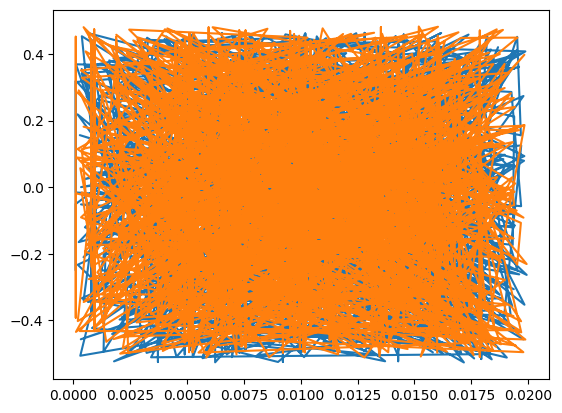

In [109]:
plt.plot(d,err[:,0])
plt.plot(d,err[:,1])
plt.show()

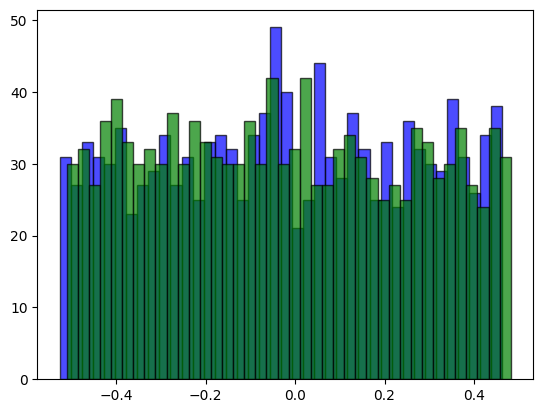

In [110]:
# print(mua,mus,d)
# print(an2[i,1],an2[i,2],an2[i,0])
# plt.plot(abs(an1[:,1]-mua))
# plt.plot(abs(an1[:,2]-mus))
plt.hist(err[:,0], bins=40,  facecolor="blue", edgecolor="black", alpha=0.7)
plt.hist(err[:,1], bins=40,  facecolor="green", edgecolor="black", alpha=0.7)
# plt.hist(abs(y_train[:,1]-mus), bins=40,  facecolor="green", edgecolor="black", alpha=0.7)
plt.show()

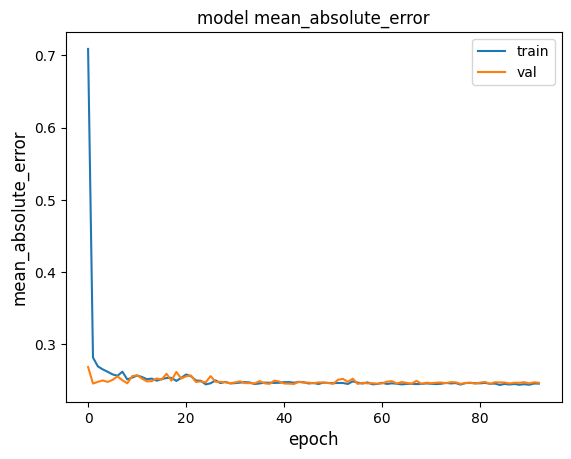

In [111]:
metric = "mean_absolute_error"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()